In [5]:
%matplotlib inline
%reload_ext autoreload
%autoreload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from IPython.display import display
from functools import partial
import seaborn as sbn

In [6]:
%autoreload
from sarnet_data_utils.data import read_results, summarize, timeout, lookup_row, classify_size
from sarnet_data_utils.integrate import integrate, calc_avg_measurements
from sarnet_data_utils.pandas import color_negative_red
from sarnet_data_utils.plot import plot_attdef as plot_single
pd.options.display.max_columns = 3000 
pd.options.display.max_seq_items = 3000 


In [7]:
%autoreload
thresholds = { 'cpu' : 85, 'sales' :200, 'logfail': 20}

data_120 = read_results('latestest', thresholds) #40 sec
data_10 = data_120[data_120['Recover'] < 10]
data_20 = data_120[data_120['Recover'] < 20] 
data_30 = data_120[data_120['Recover'] < 30] 
data_40 = data_120[data_120['Recover'] < 40] 

sum_10 = summarize(data_120, filter_failed=False, filter_nd=True, timeout=10)
sum_20 = summarize(data_120, filter_failed=False, filter_nd=True, timeout=20)
sum_30 = summarize(data_120, filter_failed=False, filter_nd=True, timeout=30)
sum_40 = summarize(data_120, filter_failed=False, filter_nd=True, timeout=40)
sum_120 = summarize(data_120, filter_failed=False, filter_nd=True)
#sum_60

## Fig.9 Successful run one Threshold (DDoS)

In [15]:
plt.rc('legend',**{'fontsize':20})
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.rc('axes', labelsize=20) 
th = {k: v for k, v in thresholds.items() if k in ['sales']}
plot_single('udp_20M_w10_dudp-rateup_r0', data_20, run=10, thresholds=th);

TypeError: cannot do label indexing on <class 'pandas.core.indexes.base.Index'> with these indexers [10] of <class 'int'>

## fig.10 failed run one threshold (PWD)

In [ ]:
th = {k: v for k, v in thresholds.items() if k in ['logfail']}
plot_single('pwd_5_w10_dudp-filter_r0', data_60, run=1, thresholds=th);

## fig.11 failed run one threshold recovered one failed (CPU)

**TODO: Current results are broken**

In [ ]:
th = {k: v for k, v in thresholds.items() if k in ['sales', 'cpu']}
plot_single('cpu_15_w10_dcaptcha_r0', data_60, run=2, thresholds=th);

## fig.12 failed run 2 tresholds (CPU)

In [ ]:
th = {k: v for k, v in thresholds.items() if k in ['sales', 'cpu']}
plot = plot_single('cpu_15_w10_dudp-rateup_r0', data_120, run=9, thresholds = th);
#plt.savefig('../plot_cpu_fail_x2.eps', format='eps')

## Table 1: Recovery success ratio

In [ ]:
df2 = sum_120.xs(key='0', level ='Relax')
df2 = classify_size(df2)
#df2 = df2.pivot_table(['detected','success'], ['Attack', 'Defence'], 'Size')
df2 = df2.pivot_table(['success'], ['Attack', 'Defence'], 'Size')


#presentation stuf.
df2 = df2.round(1)
#df2 = df2[~df2.isin([0, None]).all(1)] #remove lines with 0 or fail
df2 = df2.reindex(columns=['Light', 'Medium', 'Heavy'], level=1)
df2.index.name = 'Attack/Defence' 
df2.rename(columns={'success':'% attacks recovered'}, inplace=True)
#df2.rename(columns={'detected':'% attacks detected'}, inplace=True)
df2

## Table 2: Recovery time

In [ ]:
df = classify_size(sum_120)
df['rectime'] = df['Recover_init'] - df['Detect']

df = df.pivot_table(['rectime'], ['Attack', 'Defence','Relax'], 'Size')

df = df.xs(key='0', level ='Relax')
df = df.dropna(how='all')
df = df.fillna('fail').round(1)

df = df.reindex(columns= ['Light', 'Medium', 'Heavy'], level=1)
df.columns.names=[' ', 'Attack Size']


df


## Table 3 Effectiveness 

In [ ]:
df = data_60.copy() #make sure we don't use the main data set
df = df[df['Recover'] < 10] #this makes sure that we only calculate integral over Recovery whithin 60s 
df = summarize(df, filter_failed=False, filter_nd=True, timeout=10) 

df = classify_size(df)
df = df[df['success'] > 0]
df = df[df['Relax'] == '0']
df = df.pivot_table(['Integral'], ['Attack', 'Defence', 'Type'], 'Size')
df = df.sort_index()
df = df.dropna(how='all', axis=0)
df.columns.names=[' ', 'Attack Size']
df = df.reindex(columns= ['Light', 'Medium', 'Heavy'], level=1)
#df = df[(df != 0).any(1)] #remove 0
df = df[~df.isin([0, None]).all(1)] #remove lines with 0 or fail
df.rename(columns={'Integral':'Impact'}, inplace=True)
df = df.fillna('fail')


df

## Table 4: Recovery success ratio as time boundries are relaxed

In [ ]:
#with open('../tbl_success_relax.tex', 'w') as out:
#    out.write(df2.to_latex())
gr1 = sum_60[['success', 'Integral', 'e_Integral']]
gr1.columns = ['success_60', 'Integral_60', 'e_Integral_60']

gr2 = sum_90[['success', 'Integral', 'e_Integral']]
gr2.columns = ['success_90', 'Integral_90', 'e_Integral_90']

gr3 = sum_120[['success', 'Integral', 'e_Integral']]
gr3.columns = ['success_120', 'Integral_120', 'e_Integral_120']

merge = gr1.join([gr2, gr3], how='outer').fillna(0).round(1)
merge = merge[['success_60', 'success_90', 'success_120']]
display(merge)
    
merge = merge.xs(level=['Relax', 'Type'], key = ['0', 'sales'])
merge = merge[(merge != 0).any(1)] #remove 0

merge.columns.name='Relax timeout by:'
merge.columns = ['0% (60s)', '150% (90s)', '200% (120s)']

merge


## Table 5: Recovery success ratio as thresholds are relaxed

In [ ]:
#data selection
df2 = classify_size(sum_60)
df2 = df2.pivot_table('success', ['Attack', 'Size', 'Defence'], 'Relax')
df2 = df2[['0', '5', '10', '15']]
df2 = df2.xs(level='Size', key='Medium', drop_level=True)

#presentation stuff
df2 = df2[(df2 != 0).any(1)] #remove all 0 lines 
df2 = df2.round(1)
df2.index.name = 'Attack/Defence' 
df2.columns.name = 'Relax threshold by ' 
df2.columns = ['0%', '5%', '10%', '15%']

df2

## Figure 13: False response

In [ ]:
#example of why 'honeypot' works on ddos attack. #relax makes this worse
th = {k: v for k, v in thresholds.items() if k in ['sales', 'cpu']}
plot_single('udp_20M_w10_dhoneypot_r0', data_60, run=3, thresholds=th);


## Oddities and things to explain

In [9]:
df = sum_120.xs(['cpu', 'honeypot', '15'], level=['Attack', 'Defence', 'Relax'])
display(sum_120)

AttDef      Mean_x  \
Attack Size Defence    Relax Type                                               
cpu    10   captcha    0     cpu           cpu_10_w10_dcaptcha_r0   67.890000   
                             logfail       cpu_10_w10_dcaptcha_r0    2.939282   
                             sales         cpu_10_w10_dcaptcha_r0  187.436122   
                       10    cpu          cpu_10_w10_dcaptcha_r10   67.260000   
                             logfail      cpu_10_w10_dcaptcha_r10    2.635291   
                             sales        cpu_10_w10_dcaptcha_r10  177.172315   
                       15    cpu          cpu_10_w10_dcaptcha_r15   66.260000   
                             logfail      cpu_10_w10_dcaptcha_r15    2.612301   
                             sales        cpu_10_w10_dcaptcha_r15  175.223907   
                       5     cpu           cpu_10_w10_dcaptcha_r5   66.445000   
                             logfail       cpu_10_w10_dcaptcha_r5    2.748092   
                             sales         cpu_10_w10_dcaptcha_r5  181.390746   
            honeypot   0     cpu          cpu_10_w10_dhoneypot_r0   75.080000   
                             logfail      cpu_10_w10_dhoneypot_r0    3.414933   
                             sales        cpu_10_w10_dhoneypot_r0  217.719255   
                       10    cpu         cpu_10_w10_dhoneypot_r10   75.735000   
                             logfail     cpu_10_w10_dhoneypot_r10    3.183972   
                             sales       cpu_10_w10_dhoneypot_r10  215.589108   
                       15    cpu         cpu_10_w10_dhoneypot_r15   75.650000   
                             logfail     cpu_10_w10_dhoneypot_r15    3.327459   
                             sales       cpu_10_w10_dhoneypot_r15  217.133813   
                       5     cpu          cpu_10_w10_dhoneypot_r5   75.455000   
                             logfail      cpu_10_w10_dhoneypot_r5    3.220304   
                             sales        cpu_10_w10_dhoneypot_r5  216.543373   
            udp-filter 0     cpu        cpu_10_w10_dudp-filter_r0   95.615000   
                             logfail    cpu_10_w10_dudp-filter_r0    1.458358   
                             sales      cpu_10_w10_dudp-filter_r0   97.540564   
                       10    cpu       cpu_10_w10_dudp-filter_r10   94.915000   
                             logfail   cpu_10_w10_dudp-filter_r10    1.520330   
                             sales     cpu_10_w10_dudp-filter_r10   97.106014   
...                                                           ...         ...   
udp    40M  honeypot   15    cpu        udp_40M_w10_dhoneypot_r15   43.390000   
                             logfail    udp_40M_w10_dhoneypot_r15    1.301580   
                             sales      udp_40M_w10_dhoneypot_r15   84.295899   
                       5     cpu         udp_40M_w10_dhoneypot_r5   43.630000   
                             logfail     udp_40M_w10_dhoneypot_r5    1.171322   
                             sales       udp_40M_w10_dhoneypot_r5   83.994878   
            udp-filter 0     cpu       udp_40M_w10_dudp-filter_r0   72.055000   
                             logfail   udp_40M_w10_dudp-filter_r0    4.075167   
                             sales     udp_40M_w10_dudp-filter_r0  250.272594   
                       10    cpu      udp_40M_w10_dudp-filter_r10   72.495000   
                             logfail  udp_40M_w10_dudp-filter_r10    3.733372   
                             sales    udp_40M_w10_dudp-filter_r10  246.202995   
                       15    cpu      udp_40M_w10_dudp-filter_r15   72.890000   
                             logfail  udp_40M_w10_dudp-filter_r15    3.829751   
                             sales    udp_40M_w10_dudp-filter_r15  248.821801   
                       5     cpu       udp_40M_w10_dudp-filter_r5   72.205000   
                             logfail   udp_40M_w10_dudp-filter_r5    3.674296   
         

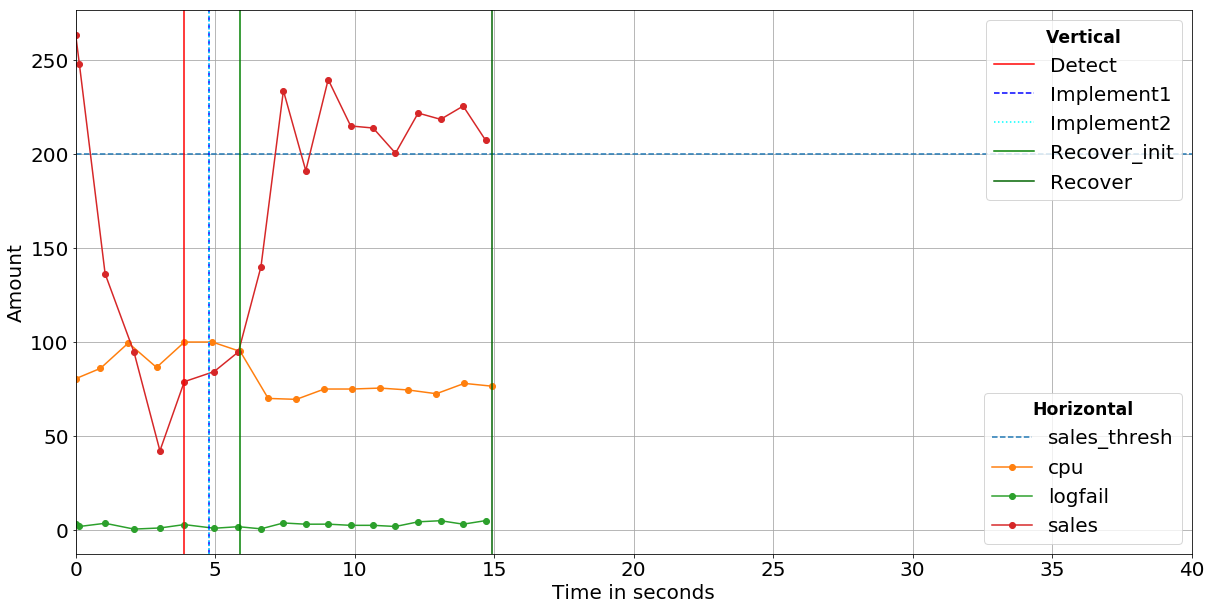

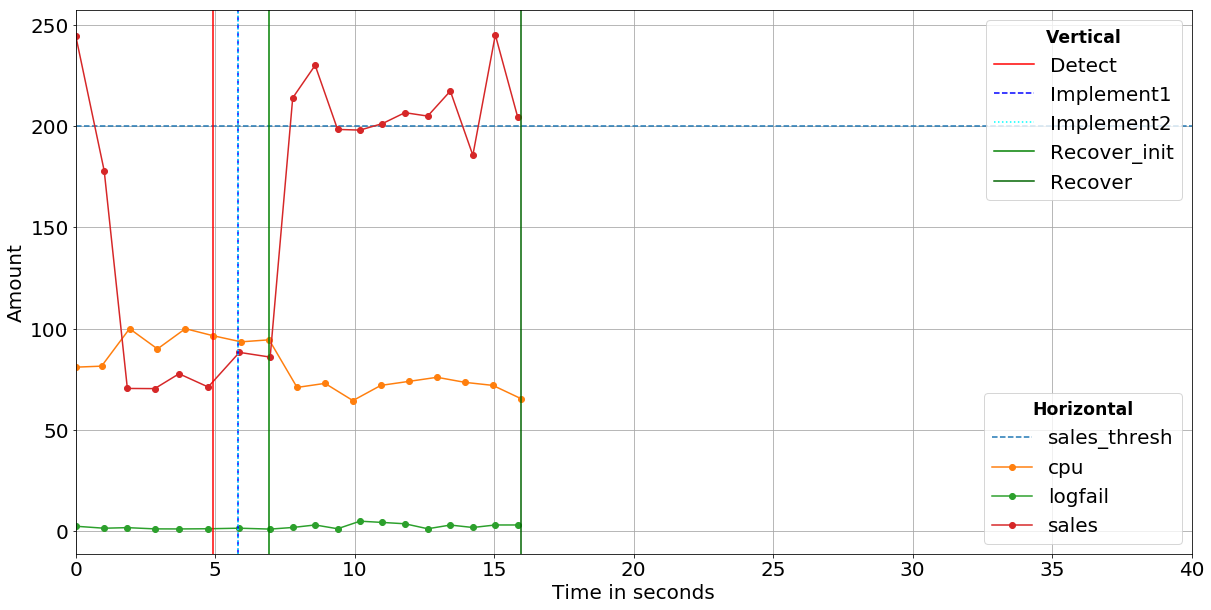

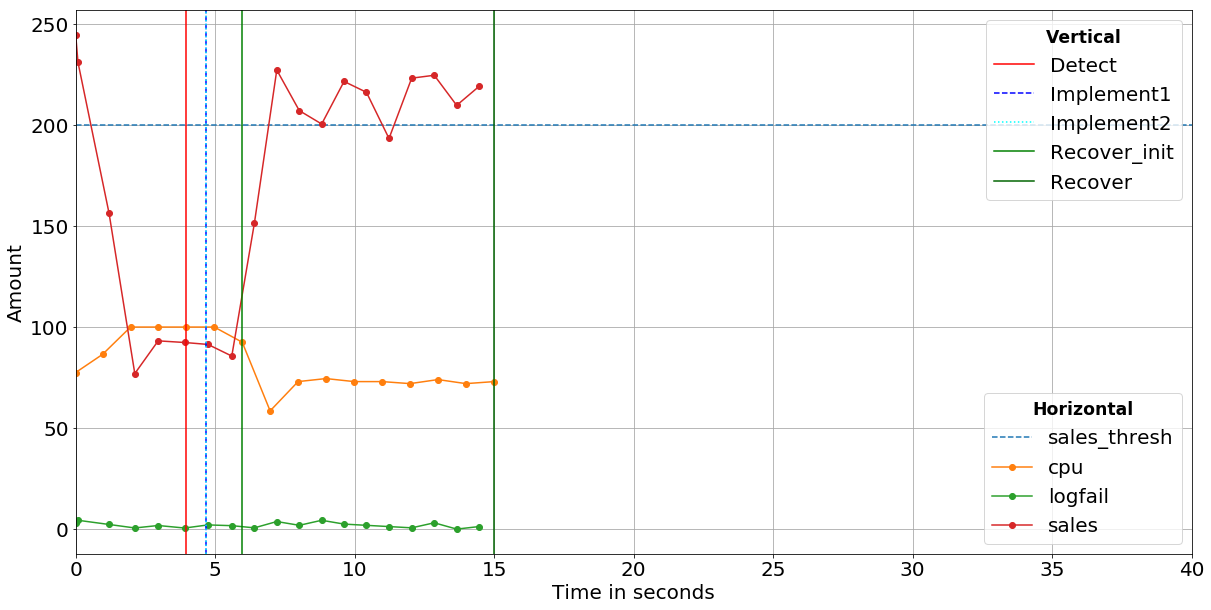

In [10]:
for run in range(3, 6):
    plot_single('cpu_15_w10_dhoneypot_r0', data_120, run=run, thresholds=th);


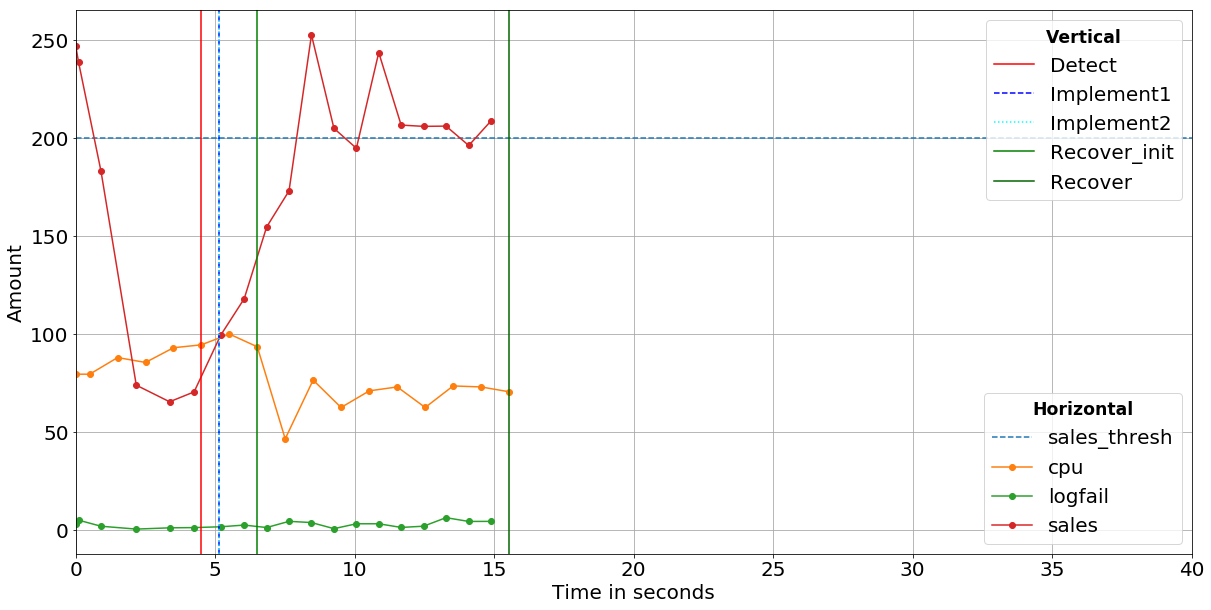

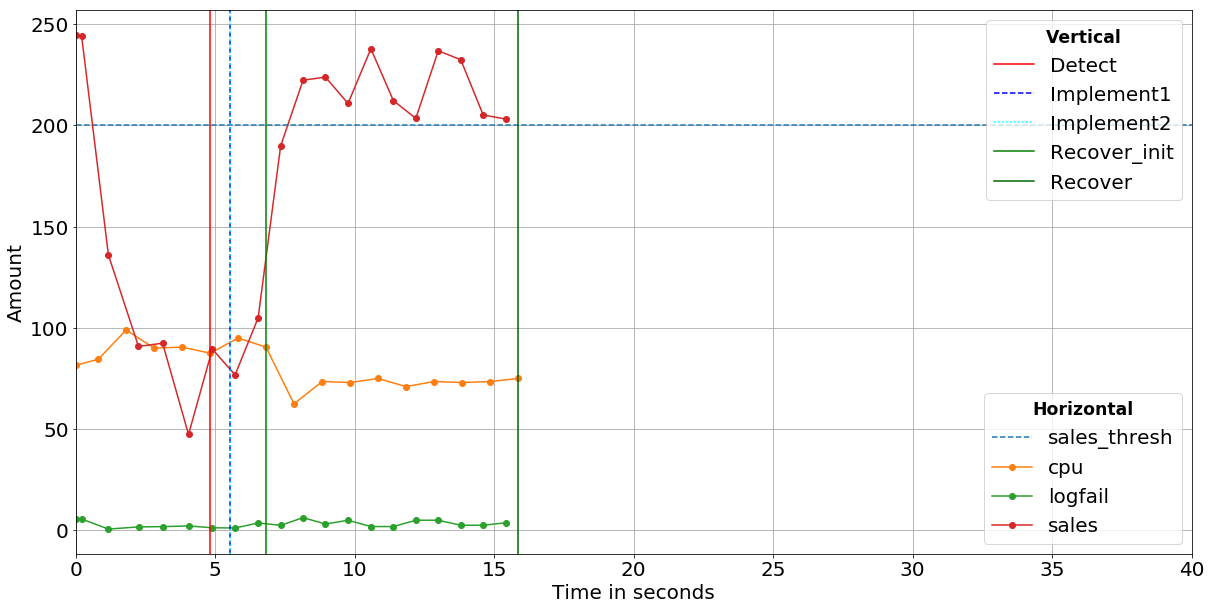

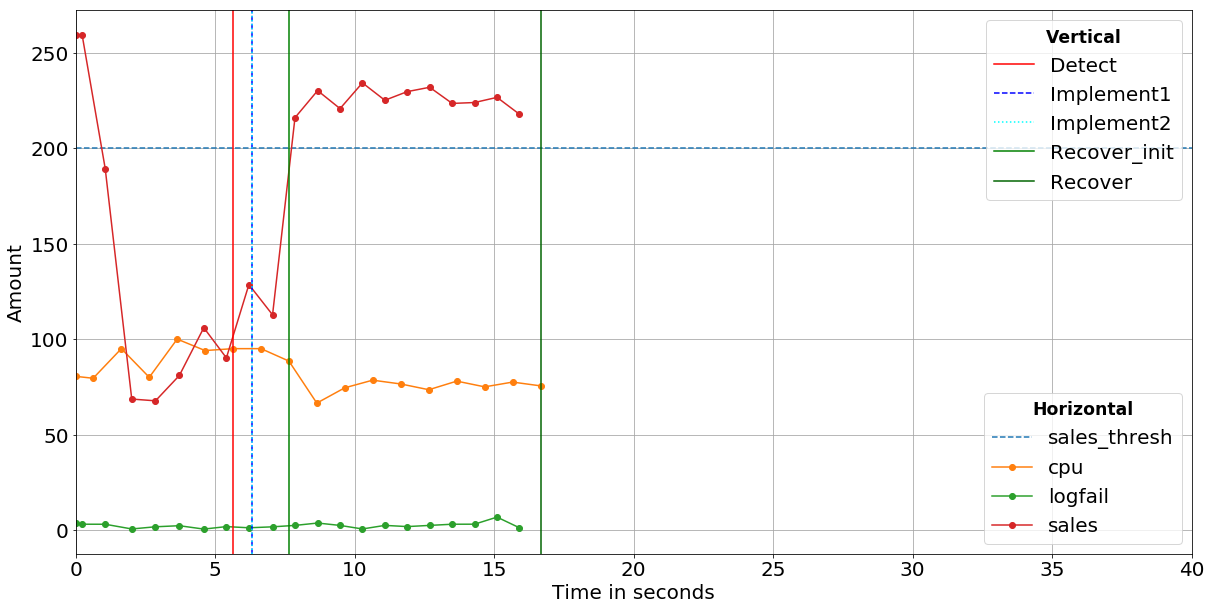

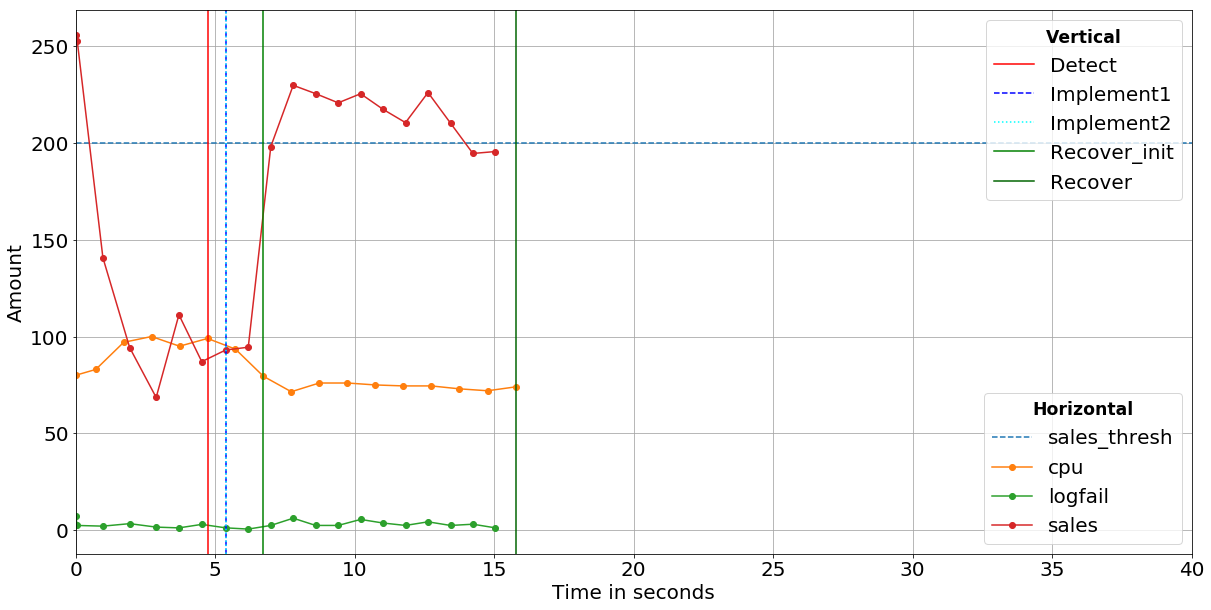

In [11]:
for run in range(1, 5):
    plot_single('cpu_10_w10_dhoneypot_r0', data_120, run=run, thresholds=th);


In [12]:
from sarnet_data_utils.radar_chart import *

[1, 2, 1]
[1, 2, 1]
[2, 2, 2]


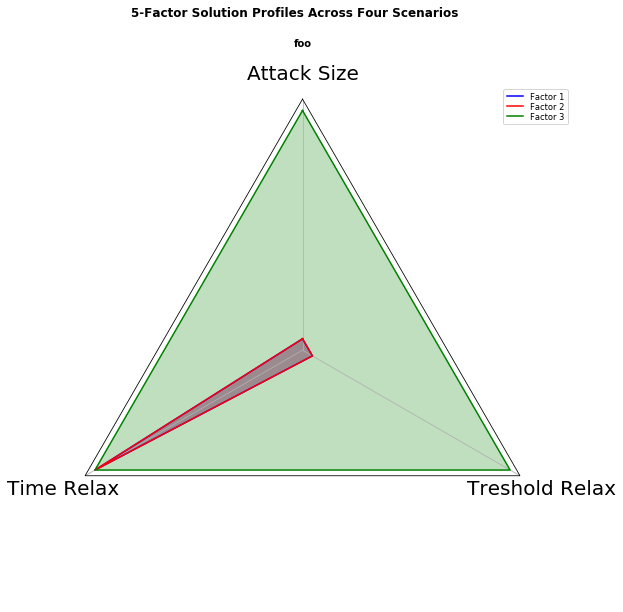

In [13]:
    N = 3
    theta = radar_factory(N, frame='polygon')
    
    #data = example_data() 
    data = [  [1, 2, 1],
              [1, 2, 1], 
              [2, 2, 2]
           ]
    title = 'foo'
    spoke_labels = ['Attack Size','Time Relax', 'Treshold Relax']

    fig, ax = plt.subplots(figsize=(9, 9), nrows=1, ncols=1,
                             subplot_kw=dict(projection='radar'))
    fig.subplots_adjust(wspace=0.25, hspace=0.20, top=0.85, bottom=0.05)

    # Plot the four cases from the example data on separate axes
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    
    
    colors = ['b', 'r', 'g']
    for d, color in zip(data, colors):
        print(d)
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25)
    ax.set_varlabels(spoke_labels)

    # add legend relative to top-left plot
    labels = ('Factor 1', 'Factor 2', 'Factor 3')
    legend = ax.legend(labels, loc=(0.9, .95),
                       labelspacing=0.1, fontsize='small')

    fig.text(0.5, 0.965, '5-Factor Solution Profiles Across Four Scenarios',
             horizontalalignment='center', color='black', weight='bold',
             size='large')

    plt.show()


In [14]:
sum_60

NameError: name 'sum_60' is not defined